# Workshop AI

## Importere data 

Først importerer vi datasettet fra csv-filen

In [2]:
from pathlib import Path

import pandas as pd

# Sett instillinger i pandas slik at det er enklere å inspisere data 
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.max_colwidth = 100

# Les data 
DATA_PATH = Path("./")
deliveries = pd.read_csv(DATA_PATH / "deliveries.csv", low_memory=False)

For å splitte et datasett inn i en "trenings"-del og en "test"-del, 
kan du bruke metoden train_test_split fra sklearn

In [3]:
 
from sklearn.model_selection import train_test_split
X, y = deliveries.drop("service_time", axis=1), deliveries["service_time"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Du har nå input for trening (X_train) og testing (X_test) og forventede labels (service-time) for trening (y_train) og for y_test. 
Det er y_test som blir "fasiten" - altså det vi ønsker å predikere. 

## Baseline solution

Vi kan så lage en enkel "baseline" løsning som bruker gjennomsnittlig service-time som prediksjon

In [4]:
avg_service_time = y_train.mean()
round(avg_service_time)

11.0

In [5]:
# Iterer over alle radene i test-data og "prediker" "avg_service_time" for all data
baseline_predictions = []
for index, row in X_test.iterrows():
    baseline_predictions.append(avg_service_time)

Nå som vi har en liste med prediksjoner, kan vi enkelt regne ut gjenommsnittlig MAE ved å bruke følgende funksjon:

In [6]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, baseline_predictions)

3.7801161373938115

Feilraten ovenfor er den vi i første omgang burde prøve å slå med maskinlæringsverktøy!

## Data Analyse

### Dataens betydning

Før vi begynner å "mate" data til en maskinlæringsmodell kan det være lurt å prøve å få en bedre 
forståelse av dataen vi har. 

Det er f.eks. ikke sikkert at all data er nyttig for å predikere - denne dataen kalles for 'støy' og vil 
skyve læringen til modellen i feil retning. 

La oss nærmere inspektere attributten 'num_frozen_bags'
ved å plotte antallet leveranser med ulike 'num_frozen_bags'

In [7]:

import seaborn as sns
import matplotlib.pyplot as plt

frozen_count = deliveries["num_bags_frozen"].value_counts()

sns.barplot(x=frozen_count.index, y=frozen_count.values)
plt.title("Nr. of Frozen bags - Distribution")
plt.ylabel("Count")
plt.xlabel("Nr. of Frozen Bags");

Deretter kan vi plotte gjenomsnittlig service-time gruppert etter 'num_frozen_bags'

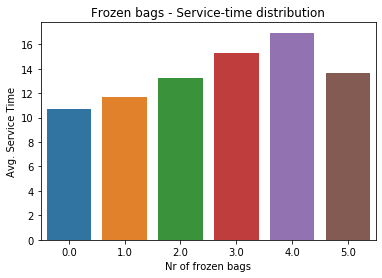

In [8]:

frozen_service = deliveries[["num_bags_frozen", "service_time"]].groupby("num_bags_frozen").mean()

sns.barplot(x=frozen_service.index, y=frozen_service.values[:, 0])
plt.title("Frozen bags - Service-time distribution")
plt.ylabel("Avg. Service Time")
plt.xlabel("Nr of frozen bags");

Hva forteller dette oss? 
Det kan se ut som gjenomsnittlig service-tid øker litt etter litt ettersom budet må levere flere frozen_bags. 
Det kan med andre ord se ut som 
attributten 'num_frozen_bags' har 'statistisk signifikans' for å predikere 'service_time'

Hva skjer hvis du bruker samme fremgangsmetode for attributten 'municipality' (kommune)?
Har denne attributten statistisk signifikans når det kommer til å predikere service-time?

### Manglende Verdier

En annen viktig ting når det kommer til å utforske data, er å se på de manglende verdiene i datasettet. 
I pandas, dersom du vil få en summering av hvor mange felter som mangler for hver attributt, kan du bruke: 

In [9]:

deliveries.isna().sum()

user_id                              0
can_select_unattended_delivery     669
floor                             2888
has_elevator                      4113
can_use_trolley                   3061
is_unattended_delivery             284
delivery_date                        0
slot_start_time                      0
slot_end_time                        0
num_boxes_dry                        0
num_boxes_cold                       0
num_bags_frozen                      0
num_products                         0
products_weight                     18
street                               0
street_number                        0
zip_code                             0
zip_place                            0
area_segment                         0
municipality                         0
service_time                         0
dtype: int64

De fleste maskinlæringsmodeller vil ikke kunne håndtere 'NaN'-verdier, og vi må derfor finne en måte å håndtere 
manglende data på. 
En helt naiv fremgangsmåte kan forkaste alle rader i datasettet som inneholder en kolonne med manglende data. 
Problemet her er dog at vi da mister mye data som vi ellers kan bruke til trening - og som igjen sørger for at vi 
får bedre prediksjoner. 

NB: For å forkaste alle rader med en 'NaN'-verdi, kan man bruke kommandoen: deliveries = deliveries.dropna(how='any')

En bedre løsning for å håndtere manglende data kan være å inter-/ekstrapolere fra andre rader i datasettet.@
Det kan f.eks. være fornuftig å anta at dersom vi ikke har attributten 'has_elevator' så kan vi alikevell anta 
at denne må være 'True' dersom bygningen det leveres til har mer enn f.eks. 4 etasjer. 

Prøv ulike metoder å håndtere manglende data på - men vær forsiktig med antakelsene du tar og undersøk hvorvidt 
ekstrapoleringen du gjør er fornuftig, gitt den dataen du har fra før.

Senere kan du prøve å mate forskjellige datasett, der du har håndtert manglende data på forskjellige måter, til 
maskinlæringsmodellene - for så å se hvilke fremgangsmåter som gir forbedret resultat. 

### Forenkle data og fjerne støy

En annen ting å ta i betrakning er hva vi skal gjøre med data som f.eks. 'delivery_data'? 
Kan vi forvente at nøyaktig leveringsdato hjelper oss med å predikere servive-time, eller betyr dette bare ekstra støy?
En fornuftig antakelse kan f.eks. være at det kun er månden som har innvirkning på service-tid og ikke eksakt dato. 
Dette høres ganske fornuftig ut - kanskje det er glatt i vintermånedene og budene må trå ekstra forsiktig? 

In [10]:
# Vi kan erstatte dato-streng med bare måneden
deliveries['delivery_date'] = deliveries['delivery_date'].apply(lambda x: int(x.split('-')[1]))
# Da gir det mening å endre navnet på feltet fra 'delivery_date' til 'delivery_month'
deliveries = deliveries.rename(columns={'delivery_date': 'delivery_month'})

Kommer du på andre måter som kan være fornuftige å gruppere data på og som kan redusere støy?

Et nyttig tips: Du kan bruke .describe() til å få en oversikt over data i en kolonne - kanskje dette kan hjelpe deg?

In [11]:
deliveries['delivery_month'].describe()

count    29083.000000
mean         6.606918
std          4.266637
min          1.000000
25%          2.000000
50%          8.000000
75%         11.000000
max         12.000000
Name: delivery_month, dtype: float64

## Lesbarhet og encoding

En siste betraktning vi må gjøre før vi mater data til en maskinlæringsmodell er hvordan vi skal representere data.
Mange maskinlæringsmodeller vil kun fungere med numerisk data. 

Her kan det være lurt å lese seg opp på one-hot-encoding: https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/

In [12]:
# Splitter datasettet i trenings- og test-data på nytt, siden vi har forandret på deliveries
from sklearn.model_selection import train_test_split
X, y = deliveries.drop("service_time", axis=1), deliveries["service_time"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# One-hot-encoding kan gjøres enkelt i python, slik:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

columns = ['month{}'.format(i) for i in range(len(X_train['delivery_month'].unique()))]
encoded_months = encoder.fit_transform(X_train['delivery_month'].values.reshape(-1,1)) # Fit encoder and transform training data

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [16]:
# Så kan du utvide X_train med den one-hot-encodede dataen, slik:
enc_df = pd.DataFrame(encoded_months.toarray(), columns=columns)
X_train = X_train.join(enc_df)
# Also remember to remove the 'delivery_month' field
X_train = X_train.drop(columns='delivery_month')

Hvilke andre verdier vil være fornuftige å 'one-hot-encode'? Trenger du å one-hot-encode test-data også?

Alt vi har gjort så langt kan vi kalle for 'data analysis' og 'feature engineering'. Ved å undersøke dataen, og endre den slik at vi reduserer støy og får numeriske verdier, blir data mye enklere å lese for en maskinlæringsmodell - noe som igjen vil reslutere i bedre (og raskere) læring. 

Nå kan du prøve å mate dataen din inn i en modell fra f.eks. catboost, xgboost eller tensorflow, for å se om du får en bedre MAE enn du gjorde med 'baseline solution'. 